# Capstone Project Reclothes - Machine Learning Section
Made by:
- Bagus Hariyadi
- Muhamad Rafli Susanto

## Import Library

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import re
import random

from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from google.colab import files

## Get dataset

In [ ]:
!gdown 1sFrhWxtEe6ktsPKY8VQ3Vkg_3tpI7B1K

Downloading...
From: https://drive.google.com/uc?id=1sFrhWxtEe6ktsPKY8VQ3Vkg_3tpI7B1K
To: /content/fabrics.zip
100% 1.23G/1.23G [00:15<00:00, 77.6MB/s]


In [ ]:
!unzip -d /content/ /content/fabrics.zip

Streaming output truncated to the last 5000 lines.
   creating: /content/fabrics/Cotton/385/
  inflating: /content/fabrics/Cotton/385/im_1.png  
  inflating: /content/fabrics/Cotton/385/im_2.png  
  inflating: /content/fabrics/Cotton/385/im_3.png  
  inflating: /content/fabrics/Cotton/385/im_4.png  
 extracting: /content/fabrics/Cotton/385/tag.txt  
   creating: /content/fabrics/Cotton/386/
  inflating: /content/fabrics/Cotton/386/im_1.png  
  inflating: /content/fabrics/Cotton/386/im_2.png  
  inflating: /content/fabrics/Cotton/386/im_3.png  
  inflating: /content/fabrics/Cotton/386/im_4.png  
 extracting: /content/fabrics/Cotton/386/tag.txt  
   creating: /content/fabrics/Cotton/387/
  inflating: /content/fabrics/Cotton/387/im_1.png  
  inflating: /content/fabrics/Cotton/387/im_2.png  
  inflating: /content/fabrics/Cotton/387/im_3.png  
  inflating: /content/fabrics/Cotton/387/im_4.png  
 extracting: /content/fabrics/Cotton/387/tag.txt  
   creating: /content/fabrics/Cotton/388/
  in

## Image and Label Preprocessing

In [ ]:
# Define the path to the dataset
dataset_path = 'fabrics/'

# Initialize lists to store the images and labels
images = []
labels = []

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Iterate through the fabric folders
for fabric_name in os.listdir(dataset_path):
    fabric_folder = os.path.join(dataset_path, fabric_name)
    
    # Iterate through the numbered folders
    for number_folder in os.listdir(fabric_folder):
        number_folder_path = os.path.join(fabric_folder, number_folder)
        
        # Retrieve the fabric images and labels
        image_paths = glob(os.path.join(number_folder_path, '*.[jp][pn]g'))  # Match .jpg and .png files
        for image_path in image_paths:
            # Load and resize the image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (200, 200))  # Resize to desired dimensions
            images.append(image)
            
            # Extract the label from the folder name
            label = fabric_name.lower()
            labels.append(label)

# Convert the labels to integer labels
integer_labels = label_encoder.fit_transform(labels)

# Convert the lists to NumPy arrays
images = np.array(images)
integer_labels = np.array(integer_labels)

# Set number of classes found
num_classes = len(set(integer_labels))

## Visualizing Data

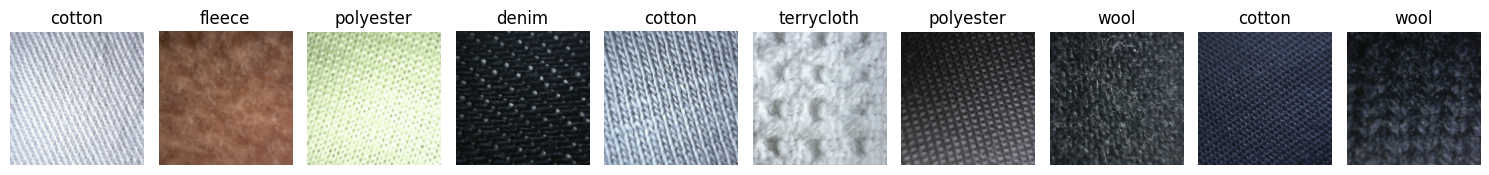

In [ ]:
# Define the number of images to display
num_images = 10

# Get the total number of available images
total_images = len(images)

# Select random indices for images
random_indices = random.sample(range(total_images), num_images)

# Create a figure and axes for subplots
fig, axes = plt.subplots(1, num_images, figsize=(15, 3), subplot_kw={'aspect': 'equal'})

# Iterate through the random indices and display the corresponding images and labels
for i, index in enumerate(random_indices):
    image = images[index]
    label = labels[index]

    # Display the image
    axes[i].imshow(image)
    axes[i].set_title(label)
    axes[i].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
print("Labels:", labels[0:10])
print("Num of class:", num_classes)

Labels: ['terrycloth', 'terrycloth', 'terrycloth', 'terrycloth', 'terrycloth', 'terrycloth', 'terrycloth', 'terrycloth', 'terrycloth', 'terrycloth']
Num of class: 9


In [ ]:
# Create a dictionary to map integer labels to original labels
label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}

# Print the label mapping
for i, label in label_mapping.items():
    print(f"{i}: {label}")

0: cotton
1: denim
2: fleece
3: nylon
4: polyester
5: silk
6: terrycloth
7: viscose
8: wool


In [ ]:
images.shape

(5092, 200, 200, 3)

## Split Dataset

In [ ]:
# Split training set
X_train, X_rem, y_train, y_rem = train_test_split(images, integer_labels, train_size=0.8, random_state=42)

# Split valid and test from remaining training set
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(4073, 200, 200, 3)
(509, 200, 200, 3)
(510, 200, 200, 3)


### Training with less images (optional cell)

In [ ]:
# Training with 1000 images first to prevent crash
X_train, y_train = X_train[:1000], y_train[0:1000]
X_val, y_val = X_val[:1000], y_val[0:1000]
X_test, y_test = X_test[:1000], y_test[0:1000]

## CNN Data Generator (Data Augmentation)

In [ ]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels, test_images, test_labels):
  train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range=30,  # Increase the rotation range for more diverse angles
    width_shift_range=0.2,  # Increase the shift range to cover a wider range of horizontal shifts
    height_shift_range=0.2,  # Increase the shift range to cover a wider range of vertical shifts
    shear_range=0.2,  # Introduce shearing to simulate fabric deformation
    zoom_range=0.3,  # Increase the zoom range for more diverse scales
    horizontal_flip=True,  # Keep horizontal flipping for additional diversity
    vertical_flip=False,  # Disable vertical flipping since fabrics usually don't have upside-down patterns
    fill_mode='nearest'  # Use 'nearest' to fill missing pixels with the nearest available value  
)

  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32) 
  validation_datagen = ImageDataGenerator(rescale = 1./255.)
  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32) 
  
  test_datagen = ImageDataGenerator(rescale = 1./255.)
  test_generator = validation_datagen.flow(x=test_images,
                                           y=test_labels,
                                           batch_size=32) 

  return train_generator, validation_generator, test_generator

In [ ]:
# Test your generators
train_generator, validation_generator, test_generator = train_val_generators(X_train, y_train, X_val, y_val, X_test, y_test)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")
print(f"Images of test generator have shape: {test_generator.x.shape}")
print(f"Labels of test generator have shape: {test_generator.y.shape}")

Images of training generator have shape: (4073, 200, 200, 3)
Labels of training generator have shape: (4073,)
Images of validation generator have shape: (509, 200, 200, 3)
Labels of validation generator have shape: (509,)
Images of test generator have shape: (510, 200, 200, 3)
Labels of test generator have shape: (510,)


In [ ]:
# Run if you want to try evaluate on training model
X_test = X_test / 255

## CNN Model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
  ])
  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 99, 99, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 128)     

### Checkpoint Callbacks

In [ ]:
# Define the file path for saving the model weights
checkpoint_path = 'model_weights_reclothes.h5'

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_weights_only=True,
    save_freq='epoch',
    save_best_only=True
)

### Model Training

In [ ]:
!gdown 1JoMsWSOTPcQ6abDdRi6Ts_vpEvDuHADe

Downloading...
From: https://drive.google.com/uc?id=1JoMsWSOTPcQ6abDdRi6Ts_vpEvDuHADe
To: /content/model_weights_400_final.h5
100% 27.3M/27.3M [00:01<00:00, 24.9MB/s]


In [ ]:
## Run if have previous model weights ##
model.load_weights('model_weights_400_final.h5')

In [ ]:
# Train the model
history = model.fit(train_generator, epochs=100, batch_size=64, validation_data=validation_generator, callbacks=[checkpoint_callback])

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Loss: {loss}, Accuracy: {accuracy}")

Epoch 1/100
128/128 [==============================] - 38s 294ms/step - loss: 0.1165 - accuracy: 0.9588 - val_loss: 0.3265 - val_accuracy: 0.9077
Epoch 2/100
128/128 [==============================] - 37s 291ms/step - loss: 0.1100 - accuracy: 0.9600 - val_loss: 0.3715 - val_accuracy: 0.8782
Epoch 3/100
128/128 [==============================] - 38s 294ms/step - loss: 0.1396 - accuracy: 0.9504 - val_loss: 0.5430 - val_accuracy: 0.8468
Epoch 4/100
128/128 [==============================] - 39s 304ms/step - loss: 0.1095 - accuracy: 0.9600 - val_loss: 0.3898 - val_accuracy: 0.8880
Epoch 5/100
128/128 [==============================] - 37s 291ms/step - loss: 0.1256 - accuracy: 0.9565 - val_loss: 0.3777 - val_accuracy: 0.8861
Epoch 6/100
128/128 [==============================] - 37s 290ms/step - loss: 0.1112 - accuracy: 0.9585 - val_loss: 0.4218 - val_accuracy: 0.8782
Epoch 7/100
128/128 [==============================] - 37s 292ms/step - loss: 0.0951 - accuracy: 0.9644 - val_loss: 0.3323 -

In [ ]:
## Save weight manually ##
model.save_weights('model_weights_0.h5')

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

16/16 [==============================] - 18s 1s/step - loss: 0.1183 - accuracy: 0.9686
Loss: 0.11825916171073914, Accuracy: 0.9686274528503418


### Model Evaluation

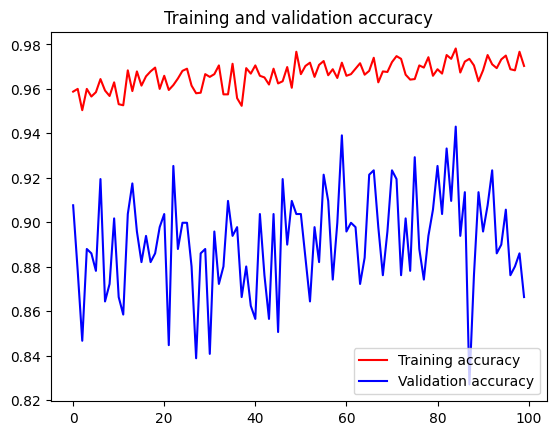

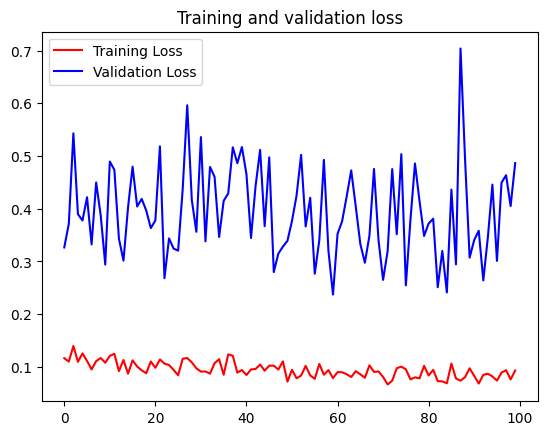

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Get test prediction

In [ ]:
pred_test = model.predict(X_test)

16/16 [==============================] - 18s 1s/step


In [ ]:
from collections import Counter

# Create a list to store the predicted labels
predicted_labels = [np.argmax(pred) for pred in pred_test]

# Count the occurrences of each predicted label
label_counter = Counter(predicted_labels)

# Print the label counter
for label, count in label_counter.items():
    print(f"{label}: {count}")

3: 21
8: 35
4: 103
1: 59
0: 223
6: 15
2: 17
5: 28
7: 9


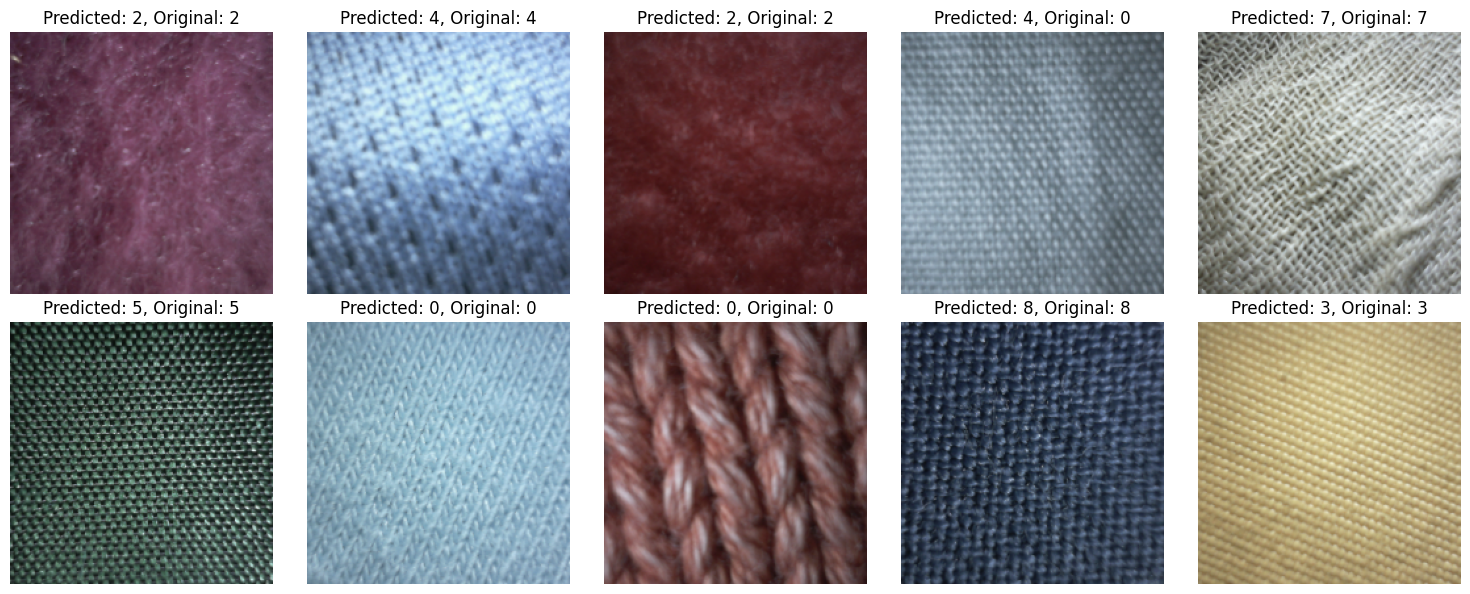

In [ ]:
# Define the number of images to display
num_images = 10

# Randomly select indices for the images to visualize
indices = np.random.choice(len(pred_test), size=num_images, replace=False)

# Create subplots for displaying multiple images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Iterate through the selected indices
for i, index in enumerate(indices):
    # Retrieve the predicted label and original label
    predicted_label = np.argmax(pred_test[index])
    original_label = y_test[index]

    # Retrieve the corresponding image
    image = X_test[index]

    # Display the image
    axes[i].imshow(image)
    axes[i].set_title(f"Predicted: {predicted_label}, Original: {original_label}")
    axes[i].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
for i in range(0, 10):
    # Retrieve the predicted label and original label
    predicted_label = np.argmax(pred_test[i])
    original_label = y_test[i]

    print(f"Prediction: {predicted_label}, Original Label: {original_label}")

Prediction: 3, Original Label: 3
Prediction: 8, Original Label: 8
Prediction: 4, Original Label: 4
Prediction: 1, Original Label: 1
Prediction: 0, Original Label: 0
Prediction: 8, Original Label: 8
Prediction: 4, Original Label: 4
Prediction: 0, Original Label: 0
Prediction: 8, Original Label: 8
Prediction: 3, Original Label: 3


### Model for User Input Predictions

In [ ]:
# Preprocessing function for Lambda Layer
def preprocess_image(image):
    # Resize the image
    image = tf.image.resize(image, [200, 200])
    # Normalize image
    image = image / 255.0
    image = tf.expand_dims(image, axis=0)
    return image

In [ ]:
num_classes = 9

model = tf.keras.models.Sequential([
    #tf.keras.layers.Lambda(preprocess_image),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
  ])
  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
model.build((200, 200, 3))

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 99, 99, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 23, 23, 128)     

In [ ]:
!gdown 1JoMsWSOTPcQ6abDdRi6Ts_vpEvDuHADe

Downloading...
From: https://drive.google.com/uc?id=1JoMsWSOTPcQ6abDdRi6Ts_vpEvDuHADe
To: /content/model_weights_400_final.h5
100% 27.3M/27.3M [00:00<00:00, 52.0MB/s]


In [ ]:
## Load weights ##
model.load_weights('model_weights_400_final.h5')

### Predicting from user input

In [ ]:
# Allow the user to upload an image file
uploaded = files.upload()

Saving im_3.png to im_3 (1).png


In [100]:
for filename in uploaded.keys():
    # Load the uploaded image
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess_image(image)
    # Make predictions using your model
    predictions = model.predict(image)
    print("Number of predictions:", len(predictions))
    print("Shape of each prediction:", predictions[0].shape)
    predicted_label = np.argmax(predictions[0])
    print(f"Prediction: {label_encoder.inverse_transform([predicted_label])[0]}")

1/1 [==============================] - 0s 107ms/step
Number of predictions: 1
Shape of each prediction: (9,)
Prediction: denim


## Saving to SavedModel Format (For VertexAI)

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/model_fabrics_classification_reclothes')

In [ ]:
!zip -r /content/saved_model.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/model_fabrics_classification_reclothes/ (stored 0%)
  adding: content/saved_model/model_fabrics_classification_reclothes/keras_metadata.pb (deflated 92%)
  adding: content/saved_model/model_fabrics_classification_reclothes/saved_model.pb (deflated 89%)
  adding: content/saved_model/model_fabrics_classification_reclothes/fingerprint.pb (stored 0%)
  adding: content/saved_model/model_fabrics_classification_reclothes/variables/ (stored 0%)
  adding: content/saved_model/model_fabrics_classification_reclothes/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved_model/model_fabrics_classification_reclothes/variables/variables.index (deflated 58%)
  adding: content/saved_model/model_fabrics_classification_reclothes/assets/ (stored 0%)


In [ ]:
files.download("/content/saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Saving to TFLite

In [ ]:
FN_SAVED_MODEL = 'fabrics_saved_model'

tf.saved_model.save(model, FN_SAVED_MODEL)

INFO:tensorflow:Assets written to: fabrics_saved_model\assets


In [ ]:
loaded = tf.saved_model.load(FN_SAVED_MODEL)

# inspeksi data input
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'conv2d_input': TensorSpec(shape=(None, 400, 400, 3), dtype=tf.float32, name='conv2d_input')})
{'dense_2': TensorSpec(shape=(None, 32), dtype=tf.float32, name='dense_2')}


gambar input berasal dari gambar dengan pixel 400 x 400 dengan rgb, kemudian dioutputkan dengan 32 unit sigmoid

In [ ]:
# convert the model into tflite and optimize it by 

converter = tf.lite.TFLiteConverter.from_saved_model(FN_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
# Save model into tflite format

tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [ ]:
# Load TFLite model and allocate tensors.
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output details of the model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare input data
input_shape = input_details[0]['shape']
X_val = np.array([X_val[0]], dtype=np.float32)  # Assuming X_val is a numpy array
input_data = X_val.reshape(input_shape)

# Set the input tensor data
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run the inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Print the prediction result
print(output_data)

[[1.3053536e-02 7.1164042e-02 7.2911382e-03 4.9725175e-04 2.8626621e-03
  1.3656616e-02 1.9590974e-02 3.5361007e-01 9.4229013e-02 1.8907064e-01
  3.0347705e-04 1.2622774e-03 5.9519112e-03 3.6729962e-02 4.5643151e-03
  2.4660498e-02 2.1800399e-03 2.8335363e-02 5.0849408e-02 4.8735738e-04
  4.0975213e-03 3.1344542e-01 1.2008548e-03 9.7471476e-04 1.9750178e-02
  9.8030031e-02 6.3917041e-04 6.9886446e-04 8.9131594e-03 9.2957914e-03
  1.4065796e-01 8.5413128e-02]]
